# Challenge 2 : Information Retrieval 新聞立場檢索

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
'''

train_data = pd.read_csv('02_Newstrain.csv')
test_data = pd.read_csv('02_Newstest.csv')

'''

## 1. 進行分詞及整理文本

#### 由於新聞報導及立場為繁體中文，因此使用先前清大深度學習課程所提供的 'big5_dict.txt' 並利用 jieba 套件進行分詞 ( 全分詞 )

In [ ]:
'''

import jieba
jieba.set_dictionary('big5_dict.txt')

'''

In [ ]:
'''

def cutwords(x) :
    
    res = []
    
    for i in range(len(x)) :
        
        res.append(jieba.lcut(x[i], cut_all = True))
      
    return res  

# , cut_all = True

cut_train = cutwords(train_data['news'])
cut_test = cutwords(test_data['news'])

cut_train_query = cutwords(train_data['query'])
cut_test_query = cutwords(test_data['query'])

'''

#### 為了使文本更加乾淨，刪除斷詞及符號。
#### 其中 'stopwords.txt' 的來源為 : 
https://github.com/tomlinNTUB/Python-in-5-days/blob/master/10-2%20%E4%B8%AD%E6%96%87%E6%96%B7%E8%A9%9E-%E7%A7%BB%E9%99%A4%E5%81%9C%E7%94%A8%E8%A9%9E.md

In [ ]:
'''

stopwords = []
with open('stopwords.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopwords.append(data)

def clean_text(x, stopwords) :
    
    res = []
    
    for i in range(len(x)) :
        
        r1 = list(filter(lambda a: a not in stopwords and a != '\n' and a != '', x[i]))
        
        r2 = [y for y in r1 if not (y.replace(".", "", 1).isdigit() or y[0] == '-' or y[1:].replace(".", "", 1).isdigit() or y[:-1].replace(".", "", 1).isdigit())]
        
        res.append(r2)
        
    return res

clean_train = clean_text(cut_train, stopwords)
clean_test = clean_text(cut_test, stopwords)

clean_train_query = clean_text(cut_train_query, stopwords)
clean_test_query = clean_text(cut_test_query, stopwords)

'''

#### 以 gensim 套件預先訓練詞向量，向量長度為 200，並刪除被沒被訓練到的詞

In [2]:
from gensim.models.word2vec import Word2Vec

In [ ]:
'''

w2v_text = clean_train + clean_test + clean_train_query + clean_test_query

model = Word2Vec(w2v_text,size=200, window=10, min_count=10, workers=6, sg=1)

def word_in_w2v(x) :
    
    res = []
    
    for i in range(len(x)) :
        
        res.append([y for y in x[i] if y in list(model.wv.vocab.keys())])
        
    return res

ptm = time.time()

clean_train = word_in_w2v(clean_train)
clean_test = word_in_w2v(clean_test)

clean_train_query = word_in_w2v(clean_train_query)
clean_test_query = word_in_w2v(clean_test_query)

time.time() - ptm

'''

In [3]:
# model.save("02_word2vec.model")
model = Word2Vec.load("02_word2vec.model")

In [ ]:
'''
train_data['news_clean'] = clean_train
test_data['news_clean'] = clean_test

train_data['query_clean'] = clean_train_query
test_data['query_clean'] = clean_test_query

train_data.to_csv('02_Newstrain_adj.csv', index = False)
test_data.to_csv('02_Newstest_adj.csv', index = False)

'''

In [4]:
import ast

train_data = pd.read_csv('02_Newstrain_adj.csv')
test_data = pd.read_csv('02_Newstest_adj.csv')

train_data['news_clean'] = train_data['news_clean'].apply(lambda x: ast.literal_eval(x))
test_data['news_clean'] = test_data['news_clean'].apply(lambda x: ast.literal_eval(x))

train_data['query_clean'] = train_data['query_clean'].apply(lambda x: ast.literal_eval(x))
test_data['query_clean'] = test_data['query_clean'].apply(lambda x: ast.literal_eval(x))


clean_train = list(train_data['news_clean'])
clean_test = list(test_data['news_clean'])

clean_train_query = list(train_data['query_clean'])
clean_test_query = list(test_data['query_clean'])

#### 大部分的新聞長度少於 400 

In [5]:
pd.DataFrame({'text length' : [len(x) for x in clean_train]}).describe()

,text length
count,3517.000000
mean,308.419392
std,164.210065
min,26.000000
25%,207.000000
50%,274.000000
75%,368.000000
max,1923.000000


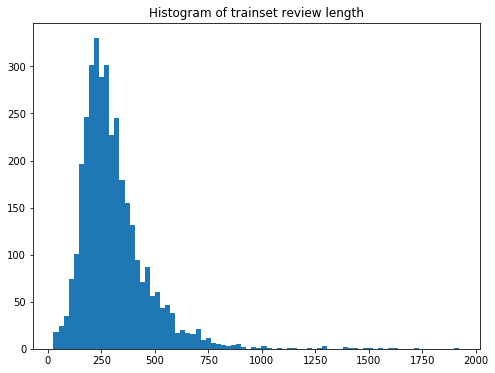

In [6]:
plt.figure(figsize = (8, 6))
plt.hist([len(x) for x in clean_train], bins = 80)
plt.title('Histogram of trainset review length')
plt.show()

In [7]:
pd.DataFrame({'text length' : [len(x) for x in clean_test]}).describe()

,text length
count,1225.000000
mean,314.640816
std,156.368490
min,25.000000
25%,213.000000
50%,278.000000
75%,385.000000
max,1402.000000


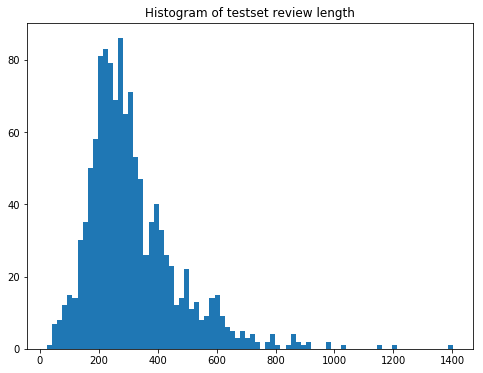

In [8]:
plt.figure(figsize = (8, 6))
plt.hist([len(x) for x in clean_test], bins = 80)
plt.title('Histogram of testset review length')
plt.show()

## 1. 特徵提取

#### 以詞向量計算新聞報導及立場的 cosine similarity 作為新的特徵
#### 特徵 1 : 平均文本的 cosine similarity
#### 特徵 2 : 兩兩詞彙 cosine similarity 的平均
#### 特徵 3 : 兩兩詞彙最小 cosine similarity 的平均
#### 特徵 4 : 兩兩詞彙最大 cosine similarity 的平均

In [9]:
def text_extraction(train_set, test_set) :
    
    train_X = train_set['news_clean']
    test_X = test_set['news_clean']
    
    query_train = train_set['query_clean']
    query_test = test_set['query_clean']


    def cosine_similarity(a, b) :

        dot = np.dot(a, b)
        norma = np.linalg.norm(a)
        normb = np.linalg.norm(b)
        cos = dot / (norma * normb)

        return cos


    train_sim1 = []

    for i in range(len(train_X)) :

        v0, v1 = np.mean(model[query_train[i]], axis = 0), np.mean(model[train_X[i]], axis = 0)

        train_sim1.append(cosine_similarity(v0, v1))


    train_sim2, train_sim3, train_sim4 = [], [], []

    for i in range(len(train_X)) :

        loc_sim2, loc_sim3, loc_sim4 = [], [], []

        for j in range(len(query_train[i])) :

            min_max = []

            for l in range(len(train_X[i])) :

                kk = cosine_similarity(model[query_train[i][j]], model[train_X[i][l]])

                loc_sim2.append(kk)

                min_max.append(kk)

            loc_sim3.append(min(min_max))

            loc_sim4.append(max(min_max))


        train_sim2.append(np.mean(loc_sim2))

        train_sim3.append(np.mean(loc_sim3))

        train_sim4.append(np.mean(loc_sim4))


    test_sim1 = []

    for i in range(len(test_X)) :

        v0, v1 = np.mean(model[query_test[i]], axis = 0), np.mean(model[test_X[i]], axis = 0)

        test_sim1.append(cosine_similarity(v0, v1))


    test_sim2, test_sim3, test_sim4 = [], [], []

    for i in range(len(test_X)) :

        loc_sim2, loc_sim3, loc_sim4 = [], [], []

        for j in range(len(query_test[i])) :

            min_max = []

            for l in range(len(test_X[i])) :

                kk = cosine_similarity(model[query_test[i][j]], model[test_X[i][l]])

                loc_sim2.append(kk)

                min_max.append(kk)

            loc_sim3.append(min(min_max))

            loc_sim4.append(max(min_max))


        test_sim2.append(np.mean(loc_sim2))

        test_sim3.append(np.mean(loc_sim3))

        test_sim4.append(np.mean(loc_sim4))
    

    train_model_X = pd.DataFrame({'query':train_set['query'], 'news':train_set['news'], 'sim1':train_sim1, 'sim2':train_sim2,'sim3':train_sim3,'sim4':train_sim4, 'relevance':train_set['relevance']})
    
    test_model_X = pd.DataFrame({'query':test_set['query'], 'news':test_set['news'], 'sim1':test_sim1, 'sim2':test_sim2,'sim3':test_sim3,'sim4':test_sim4, 'relevance':test_set['relevance']})
    
    plot_data = pd.DataFrame({'query':list(train_set['query']) * 4, 'sim':train_sim1 + train_sim2 + train_sim3 + train_sim4, 'type':['s1']*len(train_X) + ['s2']*len(train_X) + ['s3']*len(train_X) + ['s4']*len(train_X), 'relevance':list(train_set['relevance']) * 4})
    
    return train_model_X, test_model_X, plot_data

In [ ]:
'''

train_X, test_X, plot_data = text_extraction(train_data, test_data)

train_X.to_csv('02_train_model.csv', index = False, encoding='utf_8_sig')
test_X.to_csv('02_test_model.csv', index = False, encoding='utf_8_sig')
plot_data.to_csv('02_for_plot.csv', index = False, encoding='utf_8_sig')


'''

In [10]:
train_X = pd.read_csv('02_train_model.csv')
test_X = pd.read_csv('02_test_model.csv')
plot_data = pd.read_csv('02_for_plot.csv')
train_X.drop(['news'], axis = 1, inplace = True)
test_X.drop(['news', 'relevance'], axis = 1, inplace = True)

#### 針對 20 種立場觀察上述 4 種特徵對關聯性的 boxplot
#### 可以發現大部分 relevance 越高，特徵的統計量也會上升

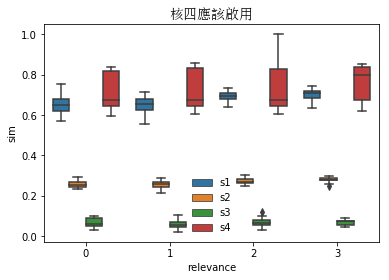

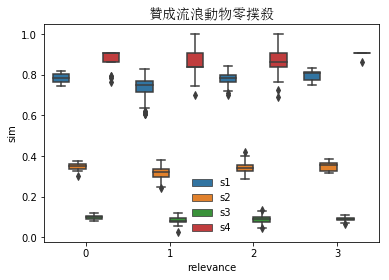

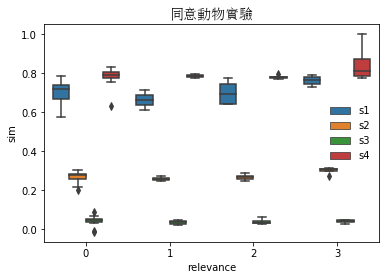

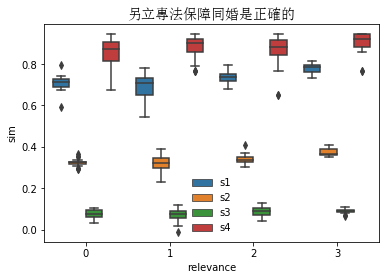

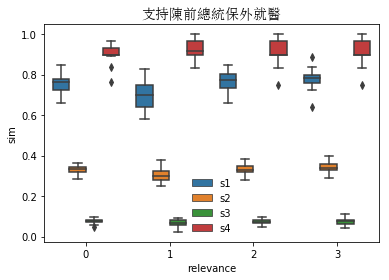

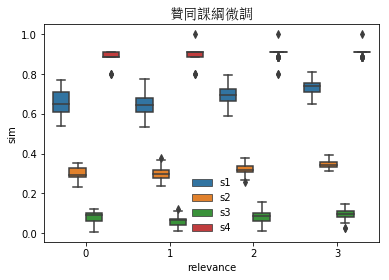

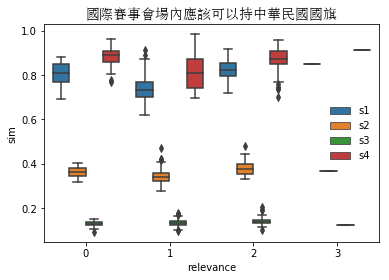

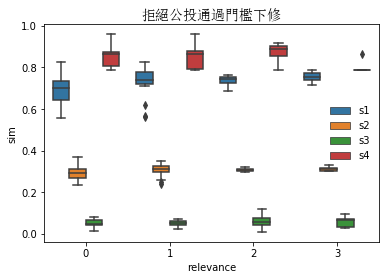

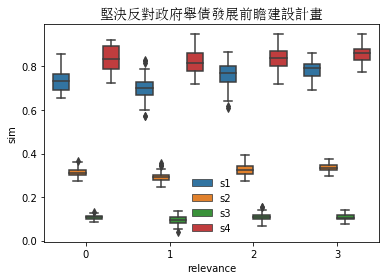

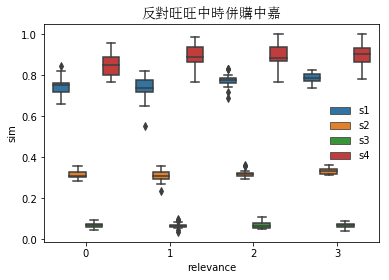

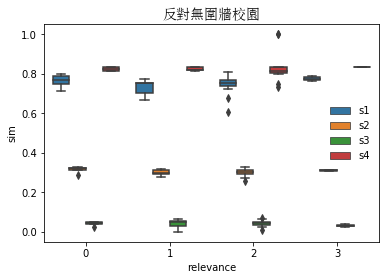

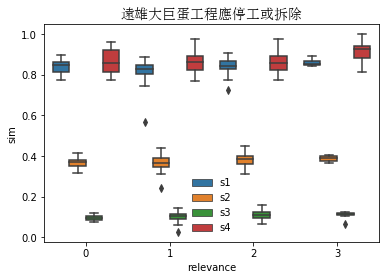

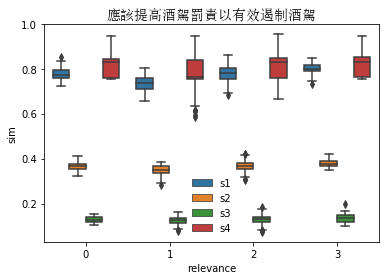

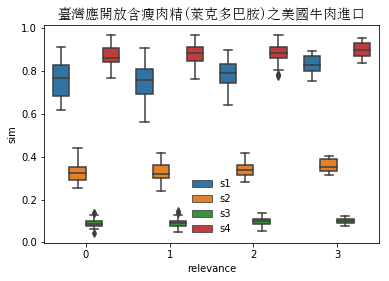

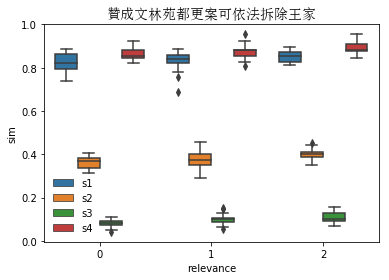

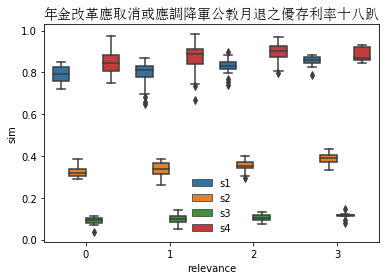

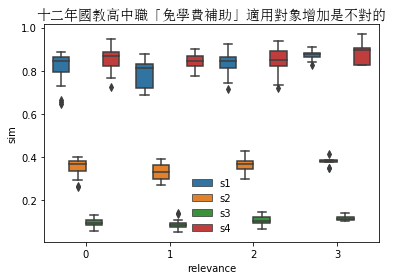

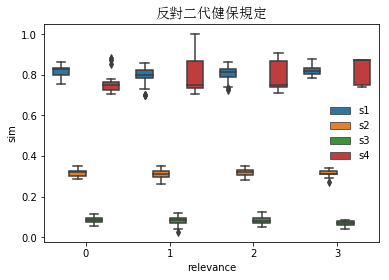

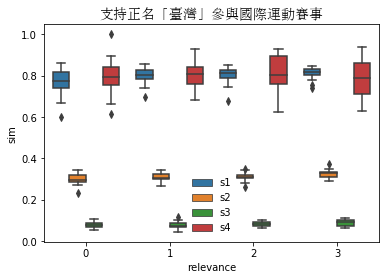

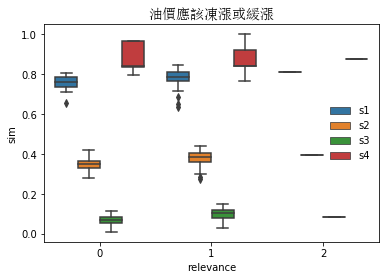

In [11]:
k = 1

for query in set(plot_data['query']) :
    
    plt.figure(k)
    
    sns.boxplot(x='relevance',y='sim',hue='type', data = plot_data[plot_data['query'] == query] )

    plt.title(query, fontproperties = font)

    plt.legend(frameon = False)
    
    k += 1
    

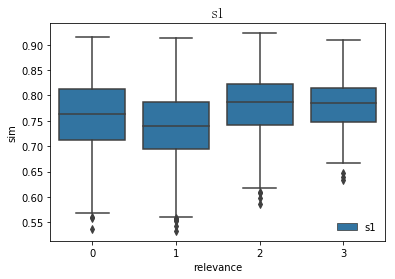

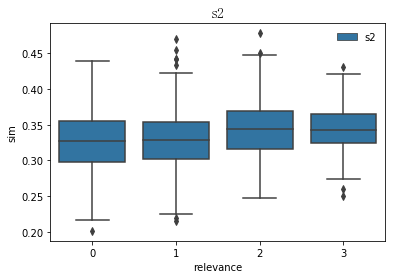

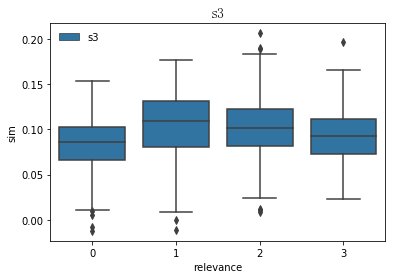

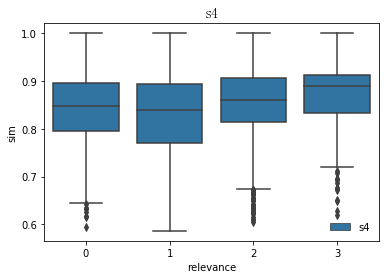

In [12]:
k = 1 

for s in ['s1', 's2', 's3', 's4'] :
    
    plt.figure(k)
    
    sns.boxplot(x='relevance',y='sim',hue='type', data = plot_data[plot_data['type'] == s] )

    plt.title(s, fontproperties = font)

    plt.legend(frameon = False)
    
    k += 1

In [ ]:
'''

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = pd.get_dummies(train_X)
X_test = pd.get_dummies(test_X)

scaler.fit(pd.concat([X_train.drop(['relevance'], axis = 1), X_test]))


gridsearch_params = [
        (maxdepth, subsample, colsample)
        for maxdepth in [i for i in range(2,6)]
        for subsample in [i/10 for i in range(7,11)]
        for colsample in [i/10 for i in range(7,11)]
    ]

train = xgb.DMatrix(scaler.transform(X_train.drop(['relevance'], axis = 1)), X_train['relevance'])

best_score = 0

for maxdepth, subsample, colsample in gridsearch_params :
    
        init_params = {

        'n_estimators':1000,
        'eta': 0.000001,
        'max_depth': maxdepth,
        'subsample': subsample,
        'colsample_bytree': colsample,
        'objective': 'multi:softprob',
        'silent': 1,
        'num_class' : 4
            
        }
        
        
        cv_output = xgb.cv(init_params, train, num_boost_round = init_params['n_estimators'], early_stopping_rounds = 15, verbose_eval=False, show_stdv=False
                 , nfold = 5)
            
        local_best = 1 - cv_output.iloc[(len(cv_output) - 1), 2]
        
        if local_best > best_score :
            
            best_score = local_best
            
            best_params = [maxdepth, subsample, colsample]
            
            best_iterations = len(cv_output)
            
            
train_params = {

    'n_estimators':best_iterations,
    'eta': 0.000001,
    'max_depth': best_params[0],
    'subsample': best_params[1],
    'colsample_bytree': best_params[2],
    'objective': 'multi:softprob',
    'silent': 1,
    'num_class' : 4

}

model = xgb.train(train_params, train, num_boost_round = best_iterations)

test = xgb.DMatrix(scaler.transform(X_test))

prediction = model.predict(test)


'''

## 3. 以 XGBoost 個別訓練 20 種立場的模型，並以 grid search 分別找出最佳模型。

#### 資料經標準化處理，以 xgboost 做 5 fold cv ，找出最佳 valid score 的參數
#### grid search 參數 : max_depth, subsample, colsample_bytree

In [17]:
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

def Model(model_train, X_test) :
    
    
    gridsearch_params = [
        (maxdepth, subsample, colsample)
        for maxdepth in [i for i in range(2,6)]
        for subsample in [i/10 for i in range(7,11)]
        for colsample in [i/10 for i in range(7,11)]
    ]
    
    best_score = 0
    
    '''
    w = Y_train.value_counts().min() / Y_train.value_counts()
    
    w_dict = dict(zip(w.index, w))
    
    train = xgb.DMatrix(X_train, Y_train, weight = np.array(Y_train.apply(lambda x: w_dict[x]))) 
    
    '''
    
    scaler = MinMaxScaler()
    
    scaler.fit(pd.concat([model_train.drop(['relevance'], axis = 1), X_test]))
    
    train = xgb.DMatrix(scaler.transform(model_train.drop(['relevance'], axis = 1)), model_train['relevance'])
    
    k = 1
    
    for maxdepth, subsample, colsample in gridsearch_params :
    
        init_params = {

        'n_estimators':1000,
        'eta': 0.000001,
        'max_depth': maxdepth,
        'subsample': subsample,
        'colsample_bytree': colsample,
        'objective': 'multi:softprob',
        'silent': 1,
        'num_class' : 4
            
        }
        
        
        cv_output = xgb.cv(init_params, train, num_boost_round = init_params['n_estimators'], early_stopping_rounds = 15, verbose_eval=False, show_stdv=False
                 , nfold = 5)
            
        local_best = 1 - cv_output.iloc[(len(cv_output) - 1), 2]
        
        if k % 16 == 0 :
        
            print('%d/%d combinations had done !'%(k, len(gridsearch_params)))
        
        k += 1
        
        if local_best > best_score :
            
            best_score = local_best
            
            best_params = [maxdepth, subsample, colsample]
            
            best_iterations = len(cv_output)
            
            
    train_params = {

        'n_estimators':best_iterations,
        'eta': 0.000001,
        'max_depth': best_params[0],
        'subsample': best_params[1],
        'colsample_bytree': best_params[2],
        'objective': 'multi:softprob',
        'silent': 1,
        'num_class' : 4
        
    }
    
    model = xgb.train(train_params, train, num_boost_round = best_iterations)
    
    test = xgb.DMatrix(scaler.transform(X_test))
    
    prediction = model.predict(test)
    
    return np.argmax(prediction, axis = 1), best_score, best_params, best_iterations, cv_output
    
    

In [18]:
import time

info = pd.DataFrame(columns = ['Query', 'Sample', 'Train Relevance', 'Best score', 'Test Relevance', 'Params', 'Iterations'])

j = 1

ptm = time.time()


for Query in list(set(train_X['query'])) :
    
    print('\n ================ %s (%d/%d) ================'%(Query, j, len(list(set(train_X['query'])))))
    
    train_model = train_X[train_X['query'] == Query].drop(['query'], axis = 1)
    
    test_model_X = test_X[test_X['query'] == Query].drop(['query'], axis = 1)
    
    pred, score, params, iterations, _ = Model(train_model, test_model_X)
       
    aa = train_model['relevance'].value_counts().sort_index()
    
    aa = np.round(aa/aa.sum(), 2)
    
    bb = pd.DataFrame(pred).iloc[:,0].value_counts().sort_index()
    
    bb = np.round(bb/bb.sum(), 2)
    
    info.loc[j] = [Query] + [len(train_model)] + [dict(zip(aa.index, aa))] + [score] + [dict(zip(bb.index, bb))] + [params] + [iterations] 
    
    print(' ')
    
    print(info.iloc[(j-1), :])
    
    test_data.iloc[test_data[test_data['query'] == Query].index,2] = pred
    
    j += 1
    

print('Running time : %.2f seconds'%(np.round(time.time()-ptm)))


 ================ 核四應該啟用 (1/20) ================
16/64 combinations had done !
32/64 combinations had done !
48/64 combinations had done !
64/64 combinations had done !
 
Query                                            核四應該啟用
Sample                                              152
Train Relevance    {0: 0.15, 1: 0.41, 2: 0.35, 3: 0.09}
Best score                                      0.55871
Test Relevance                       {1: 0.54, 2: 0.46}
Params                                    [2, 0.7, 0.7]
Iterations                                            6
Name: 1, dtype: object

 ================ 贊成流浪動物零撲殺 (2/20) ================
16/64 combinations had done !
32/64 combinations had done !
48/64 combinations had done !
64/64 combinations had done !
 
Query                                        贊成流浪動物零撲殺
Sample                                             200
Train Relevance    {0: 0.1, 1: 0.44, 2: 0.42, 3: 0.05}
Best score                                        0.62
Test Relevance    

16/64 combinations had done !
32/64 combinations had done !
48/64 combinations had done !
64/64 combinations had done !
 
Query                          贊成文林苑都更案可依法拆除王家
Sample                                      59
Train Relevance     {0: 0.36, 1: 0.44, 2: 0.2}
Best score                            0.512121
Test Relevance     {0: 0.56, 1: 0.38, 2: 0.06}
Params                           [2, 1.0, 1.0]
Iterations                                   2
Name: 15, dtype: object

 ================ 年金改革應取消或應調降軍公教月退之優存利率十八趴 (16/20) ================
16/64 combinations had done !
32/64 combinations had done !
48/64 combinations had done !
64/64 combinations had done !
 
Query                          年金改革應取消或應調降軍公教月退之優存利率十八趴
Sample                                              130
Train Relevance    {0: 0.12, 1: 0.55, 2: 0.25, 3: 0.08}
Best score                                          0.6
Test Relevance              {1: 0.91, 2: 0.07, 3: 0.02}
Params                                    [5, 0.7, 0.7

In [19]:
info

,Query,Sample,Train Relevance,Best score,Test Relevance,Params,Iterations
1,核四應該啟用,152,"{0: 0.15, 1: 0.41, 2: 0.35, 3: 0.09}",0.558710,"{1: 0.54, 2: 0.46}","[2, 0.7, 0.7]",6
2,贊成流浪動物零撲殺,200,"{0: 0.1, 1: 0.44, 2: 0.42, 3: 0.05}",0.620000,"{1: 0.4, 2: 0.6}","[2, 1.0, 0.7]",23
3,同意動物實驗,25,"{0: 0.6, 1: 0.08, 2: 0.16, 3: 0.16}",0.600000,"{0: 0.87, 3: 0.13}","[2, 0.7, 0.7]",13
4,另立專法保障同婚是正確的,107,"{0: 0.2, 1: 0.37, 2: 0.33, 3: 0.1}",0.475758,"{0: 0.19, 1: 0.33, 2: 0.29, 3: 0.19}","[3, 0.7, 0.8]",3
5,支持陳前總統保外就醫,130,"{0: 0.16, 1: 0.25, 2: 0.3, 3: 0.28}",0.453846,"{1: 0.25, 2: 0.37, 3: 0.38}","[2, 0.7, 0.7]",17
6,贊同課綱微調,240,"{0: 0.08, 1: 0.18, 2: 0.37, 3: 0.37}",0.608333,"{0: 0.02, 1: 0.18, 2: 0.3, 3: 0.5}","[4, 0.8, 0.8]",10
7,國際賽事會場內應該可以持中華民國國旗,677,"{0: 0.04, 1: 0.88, 2: 0.08, 3: 0.0}",0.902473,"{0: 0.01, 1: 0.97, 2: 0.03}","[5, 1.0, 0.8]",5
8,拒絕公投通過門檻下修,53,"{0: 0.43, 1: 0.4, 2: 0.08, 3: 0.09}",0.527273,"{0: 0.48, 1: 0.52}","[4, 0.7, 0.7]",3
9,堅決反對政府舉債發展前瞻建設計畫,348,"{0: 0.06, 1: 0.42, 2: 0.38, 3: 0.14}",0.640870,"{1: 0.39, 2: 0.6, 3: 0.01}","[4, 0.8, 0.7]",6
10,反對旺旺中時併購中嘉,108,"{0: 0.19, 1: 0.36, 2: 0.19, 3: 0.25}",0.471862,"{0: 0.06, 1: 0.35, 2: 0.06, 3: 0.52}","[5, 0.8, 0.7]",5


#### 各立場準確度經加權(樣本數比例)平均後，平均整體準確度達 64.2 %，相較隨機猜中機率的 25%，及全猜 1 的 45.2% 還來得高。

In [20]:
(info['Sample'] * info['Best score']).sum() / info['Sample'].sum() * 100

64.16696052317316

In [22]:
train_X['relevance'].value_counts() / info['Sample'].sum() * 100

1    45.237418
2    32.868922
0    11.401763
3    10.491897
Name: relevance, dtype: float64

In [23]:
test_data.drop(['news_clean', 'query_clean'], axis = 1).to_csv('./submit/02_Newstest.csv', index = False, encoding='utf_8_sig' )